<a href="https://colab.research.google.com/github/antahiap/dsr-b35/blob/main/dsr-cv/notebooks/12_VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer

- paper, [link](https://arxiv.org/abs/2010.11929)
- For tuning with new data the wights and biases should not be frozen, oposite of other NNs.

In [1]:
!pip uninstall -y transformers tokenizers datasets accelerate evaluate
!pip install transformers==4.28.0 tokenizers==0.13.3 datasets==2.12.0 accelerate==0.19.0 evaluate==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.6 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

dataset_name = "beans"
dataset = load_dataset(dataset_name)
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/b0a21163f78769a2cf11f58dfc767fb458fc7cea5c05dccc0144a2c0f0bc1292/train/bean_rust/bean_rust_train.76.jpg', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7AA577703BB0>, 'labels': 1}


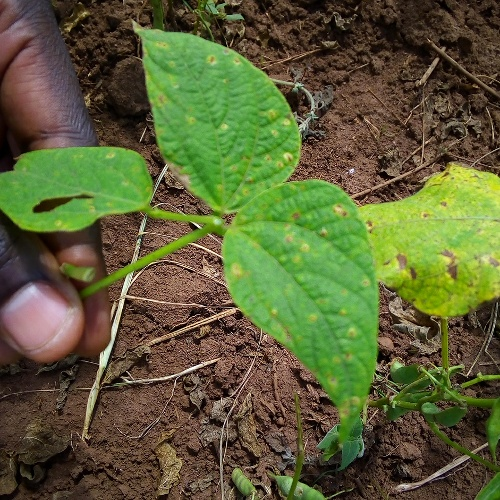

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)
bean_rust


In [3]:
from IPython.display import display

index = 667
example = dataset["train"][index]
print(example)

image = example["image"]
display(image)

labels = dataset["train"].features["labels"]
print(labels)

readable_label = labels.int2str(example["labels"])
print(readable_label)

In [4]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [5]:
feature_extractor(image, return_tensors='pt')["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [6]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [7]:
dataset = load_dataset(dataset_name)
dataset = dataset["train"]
dataset = dataset.train_test_split(0.2)

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_dataset = dataset.with_transform(transform)
prepared_dataset

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 827
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 207
    })
})

In [8]:
prepared_dataset["train"][0:2]

{'pixel_values': tensor([[[[ 0.4588,  0.4196,  0.3569,  ...,  0.1843,  0.2627,  0.0196],
          [ 0.5373,  0.6078,  0.6157,  ..., -0.0980, -0.0039,  0.2627],
          [ 0.5765,  0.6235,  0.6392,  ...,  0.0667, -0.0118,  0.2392],
          ...,
          [ 0.5059,  0.4980,  0.5373,  ...,  0.3412,  0.2549,  0.2941],
          [ 0.4588,  0.4275,  0.4118,  ...,  0.3882,  0.4039,  0.2941],
          [ 0.4275,  0.3333,  0.2941,  ...,  0.3412,  0.4824,  0.3961]],

         [[-0.1843, -0.2157, -0.2784,  ..., -0.3333, -0.2941, -0.5608],
          [-0.1137, -0.0353, -0.0196,  ..., -0.6549, -0.5451, -0.2784],
          [-0.0745, -0.0196,  0.0039,  ..., -0.5137, -0.5529, -0.2863],
          ...,
          [ 0.4196,  0.4039,  0.4353,  ..., -0.2549, -0.3412, -0.3020],
          [ 0.3647,  0.3490,  0.3412,  ..., -0.1922, -0.1765, -0.2863],
          [ 0.3255,  0.2471,  0.2314,  ..., -0.2392, -0.0824, -0.1529]],

         [[-0.0353, -0.0667, -0.1137,  ..., -0.1608, -0.0902, -0.3412],
          [ 0

In [9]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [10]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-10-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [11]:
from transformers import ViTForImageClassification

labels = dataset['train'].features['labels'].names
print(labels)

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

['angular_leaf_spot', 'bean_rust', 'healthy']


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
number_of_layers = 0
for name, param in model.named_parameters():
    print(f"Layer: {name}, Frozen: {not param.requires_grad}")
    number_of_layers += 1
print(number_of_layers)

Layer: vit.embeddings.cls_token, Frozen: False
Layer: vit.embeddings.position_embeddings, Frozen: False
Layer: vit.embeddings.patch_embeddings.projection.weight, Frozen: False
Layer: vit.embeddings.patch_embeddings.projection.bias, Frozen: False
Layer: vit.encoder.layer.0.attention.attention.query.weight, Frozen: False
Layer: vit.encoder.layer.0.attention.attention.query.bias, Frozen: False
Layer: vit.encoder.layer.0.attention.attention.key.weight, Frozen: False
Layer: vit.encoder.layer.0.attention.attention.key.bias, Frozen: False
Layer: vit.encoder.layer.0.attention.attention.value.weight, Frozen: False
Layer: vit.encoder.layer.0.attention.attention.value.bias, Frozen: False
Layer: vit.encoder.layer.0.attention.output.dense.weight, Frozen: False
Layer: vit.encoder.layer.0.attention.output.dense.bias, Frozen: False
Layer: vit.encoder.layer.0.intermediate.dense.weight, Frozen: False
Layer: vit.encoder.layer.0.intermediate.dense.bias, Frozen: False
Layer: vit.encoder.layer.0.output.dens

In [13]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=64,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [15]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_dataset["train"],
    eval_dataset=prepared_dataset["test"],
    tokenizer=feature_extractor,
)


In [16]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 238740629GF
  train_loss               =      0.1917
  train_runtime            =  0:01:15.89
  train_samples_per_second =      43.588
  train_steps_per_second   =       0.685


In [17]:
metrics = trainer.evaluate(prepared_dataset['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9517
  eval_loss               =     0.1643
  eval_runtime            = 0:00:03.44
  eval_samples_per_second =     60.165
  eval_steps_per_second   =      7.557


http://2.bp.blogspot.com/_EWuR-VzwybY/TTgPAMlniYI/AAAAAAAAEmk/qFOyCxy9I34/s1600/P1015765.JPG


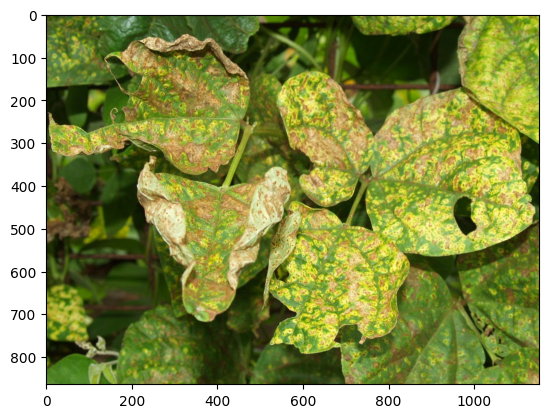

torch.Size([1, 3, 224, 224])
0
angular_leaf_spot

https://upload.wikimedia.org/wikipedia/commons/a/ac/Soybean_leaves.jpg


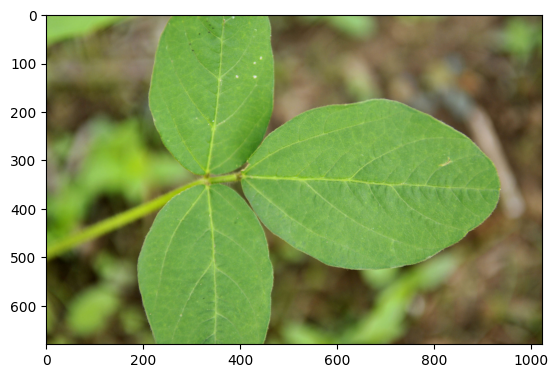

torch.Size([1, 3, 224, 224])
1
bean_rust



In [18]:
import requests
import matplotlib.pyplot as plt
import urllib
import io
from PIL import Image

urls = [
    "http://2.bp.blogspot.com/_EWuR-VzwybY/TTgPAMlniYI/AAAAAAAAEmk/qFOyCxy9I34/s1600/P1015765.JPG",
    "https://upload.wikimedia.org/wikipedia/commons/a/ac/Soybean_leaves.jpg"
]

for url in urls:
    print(url)
    with urllib.request.urlopen(url) as url:
        file = io.BytesIO(url.read())

    image = Image.open(file)
    plt.imshow(image)
    plt.show()

    #image = Image.open(requests.get(url, stream=False))
    features = feature_extractor(images=image, return_tensors="pt")
    print(features["pixel_values"].shape)
    pixel_values = features["pixel_values"].cuda()

    outputs = model(pixel_values)
    output = outputs[0].cpu().detach().numpy()[0]
    plt.show()

    logits = outputs.logits
    predicted_class_index = logits.argmax(-1).item()
    print(predicted_class_index)
    label = labels[predicted_class_index]
    print(label)
    print("")